# COMP551 Assignment 3

## Amir Abushanab - _260624419_

### To ensure the code runs correctly, please use the latest version of Jupyter Notebooks with Python 3.x

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
# First let's begin by importing all the libraries I'll likely be using during the assignment

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import csv
from collections import Counter
from operator import itemgetter
import itertools
from scipy import sparse
import re
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# To make the figures bigger
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 22})

### Q1:

No need to re-run the code in this question as the output is already in the folder.

In [3]:
yelp_train = pd.read_csv("yelp-train.txt", sep='\t', header=None)
yelp_test = pd.read_csv("yelp-test.txt", sep='\t', header=None)
yelp_valid = pd.read_csv("yelp-valid.txt", sep='\t', header=None)

IMDB_train = pd.read_csv("IMDB-train.txt", sep='\t', header=None)
IMDB_test = pd.read_csv("IMDB-test.txt", sep='\t', header=None)
IMDB_valid = pd.read_csv("IMDB-valid.txt", sep='\t', header=None)

punctuation_table = str.maketrans(dict.fromkeys(string.punctuation))
printable_table = str.maketrans(dict.fromkeys(string.printable))
TAG_RE = re.compile(r'<[^>]+>')

def create_vocab_table(data):

    """A function that returns a creates a file containing the vocabulary in a dataset, in the format
    specified in the assignment (Word, id, number of occurences)"""

    tempC = Counter()

    for index, review in data.iterrows():
        # Convert all uppercase to lower, remove punctuation and remove non-ascii characters
        S = review[0].lower().translate(punctuation_table).encode('ascii', errors='ignore').decode()
        # Remove HTML tags
        S = TAG_RE.sub('', S)
        C = Counter(S.split())
        tempC = tempC + C

    result = []
    counter = 1
    for word, value in sorted(tempC.items(), key=itemgetter(1), reverse=True):
        result.append((word, counter, value))
        counter += 1
        if counter > 10000:
            return result

    while counter <= 10000:
        result.append(("0", counter, 0))
        counter += 1

    return result


yelp_vocab = create_vocab_table(yelp_train)
IMDB_vocab = create_vocab_table(IMDB_train)

yelp_vocab_file = open("yelp-vocab.txt", 'w')
IMDB_vocab_file = open("IMDB-vocab.txt", 'w')

for line in yelp_vocab:
    yelp_vocab_file.write('\t'.join(str(s) for s in line) + '\n')

for line in IMDB_vocab:
    IMDB_vocab_file.write('\t'.join(str(s) for s in line) + '\n')

yelp_vocab_file.close()
IMDB_vocab_file.close()

In [5]:
yelp_train = pd.read_csv("yelp-train.txt", sep='\t', header=None)
yelp_test = pd.read_csv("yelp-test.txt", sep='\t', header=None)
yelp_valid = pd.read_csv("yelp-valid.txt", sep='\t', header=None)

IMDB_train = pd.read_csv("IMDB-train.txt", sep='\t', header=None)
IMDB_test = pd.read_csv("IMDB-test.txt", sep='\t', header=None)
IMDB_valid = pd.read_csv("IMDB-valid.txt", sep='\t', header=None)

punctuation_table = str.maketrans(dict.fromkeys(string.punctuation))
printable_table = str.maketrans(dict.fromkeys(string.printable))
TAG_RE = re.compile(r'<[^>]+>')

def word_to_numeric(data, translation_table):

    """Given a translation table and a data set, converts the words to their numeric representation and discards the
    words not in the translation table"""

    def column(multi_array, col):

        """A function for getting a column from a 2-D Python List"""

        return [row[col] for row in multi_array]

    words = column(translation_table, 0)
    numbers = column(translation_table, 1)

    for index, review in data.iterrows():

        S = review[0].lower().translate(punctuation_table)
        S_copy = S
        for word in S_copy.split(' '):
            try:
                S = re.sub(r"\b%s\b" % word, str(numbers[words.index(word)]), S)
            except ValueError:
                S = re.sub(r"\b%s\b" % word, "", S)

        data.iat[index, 0] = S

    return data

yelp_vocab_file = open("yelp-vocab.txt", 'r')
IMDB_vocab_file = open("IMDB-vocab.txt", 'r')

yelp_vocab_table = []
IMDB_vocab_table = []

with open("yelp-vocab.txt") as input:
    for line in input:
        temp = line.split('\t')
        yelp_vocab_table.append([temp[0], int(temp[1]), int(temp[2])])

with open("IMDB-vocab.txt") as input:
    for line in input:
        temp = line.split('\t')
        IMDB_vocab_table.append([temp[0], int(temp[1]), int(temp[2])])

# As I'd rather not overwrite the orginial dataset with mine, I've opted to change the naming convention from that specified in the assignment
pd.DataFrame.to_csv(word_to_numeric(yelp_train, yelp_vocab_table), path_or_buf="yelp-train-numeric.txt", sep='\t', header=None, index=False)
pd.DataFrame.to_csv(word_to_numeric(yelp_valid, yelp_vocab_table), path_or_buf="yelp-valid-numeric.txt", sep='\t', header=None, index=False)
pd.DataFrame.to_csv(word_to_numeric(yelp_test, yelp_vocab_table), path_or_buf="yelp-test-numeric.txt", sep='\t', header=None, index=False)
pd.DataFrame.to_csv(word_to_numeric(IMDB_train, IMDB_vocab_table), path_or_buf="IMDB-train-numeric.txt", sep='\t', header=None, index=False)
pd.DataFrame.to_csv(word_to_numeric(IMDB_valid, IMDB_vocab_table), path_or_buf="IMDB-valid-numeric.txt", sep='\t', header=None, index=False)
pd.DataFrame.to_csv(word_to_numeric(IMDB_test, IMDB_vocab_table), path_or_buf="IMDB-test-numeric.txt", sep='\t', header=None, index=False)

### Q2:

In [3]:
yelp_train = pd.read_csv("yelp-train-numeric.txt", sep='\t', header=None, encoding='ISO-8859-1', dtype=None)
yelp_test = pd.read_csv("yelp-test-numeric.txt", sep='\t', header=None, encoding='ISO-8859-1', dtype=None)
yelp_valid = pd.read_csv("yelp-valid-numeric.txt", sep='\t', header=None, encoding='ISO-8859-1', dtype=None)

IMDB_train = pd.read_csv("IMDB-train-numeric.txt", sep='\t', header=None, encoding='ISO-8859-1', dtype=None)
IMDB_test = pd.read_csv("IMDB-test-numeric.txt", sep='\t', header=None, encoding='ISO-8859-1', dtype=None)
IMDB_valid = pd.read_csv("IMDB-valid-numeric.txt", sep='\t', header=None, encoding='ISO-8859-1', dtype=None)

def binary_vectorize_toMatrix(data):
    
    """Given a numeric string generated from a vocabulary table return a binary vector representation of
         each feature as a nx10000 matrix."""
    
    result = sparse.lil_matrix((data.shape[0], 10000))
    for index, row in data.iterrows():
        if type(row[0]) == type('str'):
            for number in row[0].split(' '):
                try:
                    result[index, int(number) - 1] = 1
                except ValueError:
                    pass

    # Because spare matrices and pd dataframes don't work well together I had to result to returning a matrix rather
    # than a dataframe, even though it would have made more sense (and made my work easier) to return a dataframe...
    return result.tocsr()

def frequency_vectorize_toMatrix(data):

    """Given a numeric string generated from a vocabulary table return a frequency occurence vector representation of
         each feature as a nx10000 matrix."""

    result = sparse.lil_matrix((data.shape[0], 10000))
    for index, row in data.iterrows():
        if type(row[0]) == type('str'):
            split = row[0].split(' ')
            for number in split:
                try:
                    result[index, int(number) - 1] += (1/len(split))
                except ValueError:
                    pass

    # Because spare matrices and pd dataframes don't work well together I had to result to returning a matrix rather
    # than a dataframe, even though it would have made more sense (and made my work easier) to return a dataframe...
    return result.tocsr()

def auto_training(model, train_data, train_pred_cols, valid_data, valid_pred_cols, test_data, test_pred_cols,
                  speedy=False, parameters=None, full_results=False, model_name="", weighted_mean = True):

    """

    Returns the best trained ML model given the input data and the column(s) which are being predicted.

    Speedy === True use only 20% of the data for training, validation and testing. Should not have a significant
    affect on the result but nonetheless should be reserved for testing.

    full_results == True Display results for training and test sets in addition to the validation set

    """

    if speedy == True:
        train_data = train_data[:int((train_data.shape[0] * 0.2))]
        train_pred_cols = train_pred_cols[:int((train_pred_cols.shape[0] * 0.2))]
        valid_data = valid_data[:int((valid_data.shape[0] * 0.2))]
        valid_pred_cols = valid_pred_cols[:int((valid_pred_cols.shape[0] * 0.2))]
        test_data = test_data[:int((test_data.shape[0] * 0.2))]
        test_pred_cols = test_pred_cols[:int((test_pred_cols.shape[0] * 0.2))]

    if model != None or parameters == None:
        print("------------------------------------------------")
        model.fit(train_data, train_pred_cols)
        pred_vals = pd.DataFrame(model.predict(train_data)).astype(int)
        print(model)
        print("*****************")
        print("Train Data Performance:")
        print("*****************")
        print("Confusion Matrix: \n", confusion_matrix(train_pred_cols.astype(int), pred_vals))
        print("F1 Score: ", f1_score(train_pred_cols.astype(int), pred_vals, average='micro'))
        print("Mean F1 Score: ", f1_score(train_pred_cols.astype(int), pred_vals, average='macro'))
        
        if weighted_mean:
            print("Weighted Mean F1 Score: ", f1_score(train_pred_cols.astype(int), pred_vals, average='weighted'))
        
        print("*****************")
        pred_vals = pd.DataFrame(model.predict(valid_data)).astype(int)
        print("Validation Data Performance:")
        print("*****************")
        print("Confusion Matrix: \n", confusion_matrix(valid_pred_cols.astype(int), pred_vals))
        print("F1 Score: ", f1_score(valid_pred_cols.astype(int), pred_vals, average='micro'))
        print("Mean F1 Score: ", f1_score(valid_pred_cols.astype(int), pred_vals, average='macro'))
        
        if weighted_mean:
            print("Weighted Mean F1 Score: ", f1_score(valid_pred_cols.astype(int), pred_vals, average='weighted'))
        
        print("*****************")
        pred_vals = pd.DataFrame(model.predict(test_data)).astype(int)
        print("Test Data Performance:")
        print("*****************")
        print("Confusion Matrix: \n", confusion_matrix(test_pred_cols.astype(int), pred_vals))
        print("F1 Score: ", f1_score(test_pred_cols.astype(int), pred_vals, average='micro'))
        print("Mean F1 Score: ", f1_score(test_pred_cols.astype(int), pred_vals, average='macro'))
        
        if weighted_mean:
            print("Weighted Mean F1 Score: ", f1_score(test_pred_cols.astype(int), pred_vals, average='weighted'))
        
        print("------------------------------------------------")
        print("\n")

        return model

    best_model = None
    best_f1 = -1

    if model_name == "Bernoulli" or model_name == "Multinomial":

        for alpha in parameters.get('alpha'):
            for fit_prior in parameters.get('fit_prior'):
                if model_name == "Bernoulli":
                    model = BernoulliNB(alpha=alpha, fit_prior=fit_prior)
                else:
                    model = MultinomialNB(alpha=alpha, fit_prior=fit_prior)

                model.fit(train_data, train_pred_cols)
                temp_pred_vals = pd.DataFrame(model.predict(valid_data)).astype(int)
                new_f1 = f1_score(valid_pred_cols.astype(int), temp_pred_vals, average='weighted')

                if best_f1 < new_f1:
                    best_f1 = new_f1
                    best_model = model

    if model_name == "DecisionTree":

        for criteria in parameters.get("criteria"):

            for splitter in parameters.get("splitter"):

                for class_weight in parameters.get("class_weight"):

                    for min_samples_split in parameters.get("min_samples_split"):

                        for min_samples_leaf in parameters.get("min_samples_leaf"):

                            for max_depth in parameters.get("max_depth"):

                                model = DecisionTreeClassifier(class_weight=class_weight, criterion=criteria,
                                                               splitter=splitter, min_samples_leaf=min_samples_leaf,
                                                               min_impurity_split=min_samples_split, max_depth=max_depth)

                                model.fit(train_data, train_pred_cols)
                                temp_pred_vals = pd.DataFrame(model.predict(valid_data)).astype(int)
                                new_f1 = f1_score(valid_pred_cols.astype(int), temp_pred_vals, average='weighted')

                                if best_f1 < new_f1:
                                    best_f1 = new_f1
                                    best_model = model

    if model_name == "LinearSVC":

            for penalty in parameters.get("penalty"):

                for loss in parameters.get("loss"):

                    # Necessary because the combination of l1 loss and a penalty is not doable
                    if penalty == 'l1' and (loss == 'hinge' or loss == 'squared_hinge'):
                        continue

                    for tol in parameters.get("tol"):

                        for C in parameters.get("C"):

                            for max_iter in parameters.get("max_iter"):

                                for class_weight in parameters.get("class_weight"):

                                    model = LinearSVC(penalty=penalty, loss=loss, tol=tol, C=C, max_iter=max_iter,
                                                      class_weight=class_weight)

                                    model.fit(train_data, train_pred_cols)
                                    temp_pred_vals = pd.DataFrame(model.predict(valid_data)).astype(int)
                                    new_f1 = f1_score(valid_pred_cols.astype(int), temp_pred_vals, average='weighted')

                                    if best_f1 < new_f1:
                                        best_f1 = new_f1
                                        best_model = model

    print("------------------------------------------------")
    print(best_model)

    if full_results:

        pred_vals = pd.DataFrame(best_model.predict(train_data)).astype(int)
        print("*****************")
        print("Train Data Performance:")
        print("*****************")
        print("Confusion Matrix: \n", confusion_matrix(train_pred_cols.astype(int), pred_vals))
        print("F1 Score: ", f1_score(train_pred_cols.astype(int), pred_vals, average='micro'))
        print("Mean F1 Score: ", f1_score(train_pred_cols.astype(int), pred_vals, average='macro'))
        
        if weighted_mean:
            print("Weighted Mean F1 Score: ", f1_score(train_pred_cols.astype(int), pred_vals, average='weighted'))
        
        print("*****************")

    pred_vals = pd.DataFrame(best_model.predict(valid_data)).astype(int)
    print("Validation Data Performance:")
    print("*****************")
    print("Confusion Matrix: \n", confusion_matrix(valid_pred_cols.astype(int), pred_vals))
    print("F1 Score: ", f1_score(valid_pred_cols.astype(int), pred_vals, average='micro'))
    print("Mean F1 Score: ", f1_score(valid_pred_cols.astype(int), pred_vals, average='macro'))
    
    if weighted_mean:
        print("Weighted Mean F1 Score: ", f1_score(valid_pred_cols.astype(int), pred_vals, average='weighted'))
    
    print("*****************")

    if full_results:

        pred_vals = pd.DataFrame(best_model.predict(test_data)).astype(int)
        print("Test Data Performance:")
        print("*****************")
        print("Confusion Matrix: \n", confusion_matrix(test_pred_cols.astype(int), pred_vals))
        print("F1 Score: ", f1_score(test_pred_cols.astype(int), pred_vals, average='micro'))
        print("Mean F1 Score: ", f1_score(test_pred_cols.astype(int), pred_vals, average='macro'))
        
        if weighted_mean:
            print("Weighted Mean F1 Score: ", f1_score(test_pred_cols.astype(int), pred_vals, average='weighted'))
        
        print("------------------------------------------------")

    print("\n")

    return best_model

    
yelp_train_binary_matrix = binary_vectorize_toMatrix(yelp_train)
yelp_valid_binary_matrix = binary_vectorize_toMatrix(yelp_valid)
yelp_test_binary_matrix = binary_vectorize_toMatrix(yelp_test)

The uniform random and majority classifiers' results (to provide a baseline for comparision):

In [5]:
yelp_uniform_random_classifier = DummyClassifier(strategy='uniform')

yelp_uniform_random_classifier = auto_training(yelp_uniform_random_classifier, yelp_train_binary_matrix, yelp_train[1], yelp_valid_binary_matrix,
              yelp_valid[1], yelp_test_binary_matrix, yelp_test[1], speedy=False, full_results=True)

------------------------------------------------
DummyClassifier(constant=None, random_state=None, strategy='uniform')
*****************
Train Data Performance:
*****************
Confusion Matrix: 
 [[101  99 103 119 100]
 [123 131 131 135 121]
 [193 206 198 211 189]
 [492 486 533 473 484]
 [494 463 468 487 460]]
F1 Score:  0.194714285714
Mean F1 Score:  0.177426143981
Weighted Mean F1 Score:  0.212221030037
*****************
Validation Data Performance:
*****************
Confusion Matrix: 
 [[13 18 26 13 14]
 [21 27 11 17 20]
 [35 33 28 36 32]
 [66 68 65 83 74]
 [64 59 49 46 82]]
F1 Score:  0.233
Mean F1 Score:  0.209997350726
Weighted Mean F1 Score:  0.25322055822
*****************
Test Data Performance:
*****************
Confusion Matrix: 
 [[ 28  26  27  27  35]
 [ 25  49  52  33  31]
 [ 54  65  67  55  59]
 [139 159 141 152 111]
 [124 117 144 151 129]]
F1 Score:  0.2125
Mean F1 Score:  0.195220501365
Weighted Mean F1 Score:  0.229222520896
-----------------------------------------

In [6]:
yelp_majority_classifier = DummyClassifier(strategy='most_frequent')

yelp_majority_classifier = auto_training(yelp_majority_classifier, yelp_train_binary_matrix, yelp_train[1], yelp_valid_binary_matrix,
              yelp_valid[1], yelp_test_binary_matrix, yelp_test[1], speedy=False, full_results=True)

------------------------------------------------
DummyClassifier(constant=None, random_state=None, strategy='most_frequent')
*****************
Train Data Performance:
*****************
Confusion Matrix: 
 [[   0    0    0  522    0]
 [   0    0    0  641    0]
 [   0    0    0  997    0]
 [   0    0    0 2468    0]
 [   0    0    0 2372    0]]
F1 Score:  0.352571428571
Mean F1 Score:  0.104267004647
Weighted Mean F1 Score:  0.183807833907
*****************
Validation Data Performance:
*****************
Confusion Matrix: 
 [[  0   0   0  84   0]
 [  0   0   0  96   0]
 [  0   0   0 164   0]
 [  0   0   0 356   0]
 [  0   0   0 300   0]]
F1 Score:  0.356
Mean F1 Score:  0.105014749263
Weighted Mean F1 Score:  0.186926253687
*****************
Test Data Performance:
*****************
Confusion Matrix: 
 [[  0   0   0 143   0]
 [  0   0   0 190   0]
 [  0   0   0 300   0]
 [  0   0   0 702   0]
 [  0   0   0 665   0]]
F1 Score:  0.351
Mean F1 Score:  0.103923019985
Weighted Mean F1 Score:  

Tuning the (Bernoulli) Naive Bayes model - first I tried setting fit_prior to both true and false and then tried varying the values of $\alpha$ by factors of 10 (i.e 0.0000001, 0.000001,...100) to narrow down the range.

In [7]:
naive_bayes_params = dict(alpha=np.array([100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]),
                          fit_prior=[True, False])

yelp_binary_NBC = auto_training(None, yelp_train_binary_matrix, yelp_train.loc[:, [1]], yelp_valid_binary_matrix,
              yelp_valid.loc[:, [1]], yelp_test_binary_matrix, yelp_test.loc[:, [1]], speedy=False,
              parameters=naive_bayes_params, model_name="Bernoulli")

------------------------------------------------
BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=False)
Validation Data Performance:
*****************
Confusion Matrix: 
 [[ 32  13   8   9  22]
 [ 11  22  19  24  20]
 [  6   9  44  55  50]
 [  6  10  33 150 157]
 [  5   8  12  93 182]]
F1 Score:  0.43
Mean F1 Score:  0.394368082102
Weighted Mean F1 Score:  0.4204532879
*****************




Then narrowed down the range of $\alpha$s between 0.09 and 0.002 and reported the complete preformance

In [8]:
narrowed_naive_bayes_params = dict(alpha=np.arange(0.002, 0.099, 0.001), fit_prior=[False])

yelp_binary_NBC = auto_training(None, yelp_train_binary_matrix, yelp_train.loc[:, [1]], yelp_valid_binary_matrix,
              yelp_valid.loc[:, [1]], yelp_test_binary_matrix, yelp_test.loc[:, [1]], speedy=False, full_results=True,
              parameters=narrowed_naive_bayes_params, model_name="Bernoulli")

------------------------------------------------
BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=False)
*****************
Train Data Performance:
*****************
Confusion Matrix: 
 [[ 403    3    6    4  106]
 [  13  448   14   31  135]
 [   5   11  721   39  221]
 [   9   27   38 1590  804]
 [  12   21   44  188 2107]]
F1 Score:  0.752714285714
Mean F1 Score:  0.77529586098
Weighted Mean F1 Score:  0.754566461109
*****************
Validation Data Performance:
*****************
Confusion Matrix: 
 [[ 32  13   8   9  22]
 [ 11  22  19  24  20]
 [  6   9  44  55  50]
 [  6  10  33 150 157]
 [  5   8  12  93 182]]
F1 Score:  0.43
Mean F1 Score:  0.394368082102
Weighted Mean F1 Score:  0.4204532879
*****************
Test Data Performance:
*****************
Confusion Matrix: 
 [[ 46  28  22  13  34]
 [ 26  38  38  36  52]
 [ 12  26  66  97  99]
 [  9  18  66 310 299]
 [  9  10  25 210 411]]
F1 Score:  0.4355
Mean F1 Score:  0.371226018906
Weighted Mean F1 Score:  0.4227

Next for the Decision Tree Classifier, I tried using both Gini and Entropy (information gain) criterion, using best and random splitting criteria, using no and balanced class weights, and varying the min_samples_per_split from 2 to 10, the min_sample_leaf from 1 to 10, and the max_depth from 1 to 10.

In [9]:
decision_tree_params = dict(criteria=['gini', 'entropy'], splitter=['best', 'random'], max_depth=list(range(1, 10)),
                            min_samples_split= list(range(2, 10)), min_samples_leaf=list(range(1, 10)), class_weight=["balanced", None])

yelp_binary_DTC = auto_training(None, yelp_train_binary_matrix, yelp_train.loc[:, [1]], yelp_valid_binary_matrix,
              yelp_valid.loc[:, [1]], yelp_test_binary_matrix, yelp_test.loc[:, [1]], speedy=False,
              parameters=decision_tree_params, model_name="DecisionTree")

------------------------------------------------
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=2,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Validation Data Performance:
*****************
Confusion Matrix: 
 [[ 16   1   4  44  19]
 [  7   1   6  58  24]
 [  2   6   5 112  39]
 [  4   2   7 268  75]
 [  6   3   5 177 109]]
F1 Score:  0.399
Mean F1 Score:  0.250570007231
Weighted Mean F1 Score:  0.336479852912
*****************




It seems that increasing the max_depth may produce better results, so let's try increasing it while also varying values on min_samples_leaf and min_samples_split.

In [10]:
narrowed_decision_tree_params = dict(criteria=['entropy'], splitter=['best'], max_depth=list(range(1, 30)),
                            min_samples_split= list(range(2, 20)), min_samples_leaf=list(range(1, 20)), class_weight=[None])

yelp_binary_DTC = auto_training(None, yelp_train_binary_matrix, yelp_train.loc[:, [1]], yelp_valid_binary_matrix,
              yelp_valid.loc[:, [1]], yelp_test_binary_matrix, yelp_test.loc[:, [1]], speedy=False, full_results = True, 
              parameters=narrowed_decision_tree_params, model_name="DecisionTree")

------------------------------------------------
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=18,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=2,
            min_samples_leaf=14, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
*****************
Train Data Performance:
*****************
Confusion Matrix: 
 [[ 162   55   34  138  133]
 [  46  122   50  284  139]
 [  26   62  141  601  167]
 [  52   48   75 1719  574]
 [  50   27   30 1324  941]]
F1 Score:  0.440714285714
Mean F1 Score:  0.361368779789
Weighted Mean F1 Score:  0.414754043665
*****************
Validation Data Performance:
*****************
Confusion Matrix: 
 [[ 20  14   4  24  22]
 [  8  10  11  38  29]
 [ 10   8  21  78  47]
 [  7  11  19 233  86]
 [ 14   9   4 158 115]]
F1 Score:  0.399
Mean F1 Score:  0.302507182891
Weighted Mean F1 Score:  0.36957979

Lastly for the Linear SVC I will start by varying the penalty between l1 and l2, the loss between hinged and square-hinged, the class_weight between balanced and unbalanced, the penalty parameter between 10000 and 0.0000001 by powers of 10, and the tolerance between 1 and 0.00000001 by powers of 10.

In [11]:
linear_SVC_params = dict(penalty=['l1', 'l2'], loss=['hinge', 'squared_hinge'], class_weight=[None, 'balanced'],
                         tol=np.array([1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.0000001, 0.00000001]), max_iter =[1000],
                         C=([1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.0000001, 0.00000001]))

yelp_binary_LSVC = auto_training(None, yelp_train_binary_matrix, yelp_train.loc[:, [1]], yelp_valid_binary_matrix,
              yelp_valid.loc[:, [1]], yelp_test_binary_matrix, yelp_test.loc[:, [1]], speedy=False,
              parameters= linear_SVC_params, model_name="LinearSVC")

------------------------------------------------
LinearSVC(C=0.001, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None,
     tol=0.10000000000000001, verbose=0)
Validation Data Performance:
*****************
Confusion Matrix: 
 [[ 53  17   5   3   6]
 [ 24  29  21  12  10]
 [ 10  35  57  44  18]
 [ 17  15  40 166 118]
 [ 18  11  11  58 202]]
F1 Score:  0.507
Mean F1 Score:  0.464025309295
Weighted Mean F1 Score:  0.50367523461
*****************




Now with the hyperparemters found I will narrow the hyperparameters search space and increase the max_iterations and see if that produces better results.

In [12]:
narrowed_linear_SVC_params = dict(penalty=['l2'], loss=['squared_hinge'], class_weight=['balanced'],
                         tol=np.array([3, 2, 1]), max_iter=[1000, 10000], C=np.arange(0.0002, 0.0099, 0.0001))

yelp_binary_LSVC = auto_training(None, yelp_train_binary_matrix, yelp_train.loc[:, [1]], yelp_valid_binary_matrix,
              yelp_valid.loc[:, [1]], yelp_test_binary_matrix, yelp_test.loc[:, [1]], speedy=False, full_results= True, 
              parameters= narrowed_linear_SVC_params, model_name="LinearSVC")

------------------------------------------------
LinearSVC(C=0.0064000000000000012, class_weight='balanced', dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=10000, multi_class='ovr', penalty='l2', random_state=None,
     tol=3, verbose=0)
*****************
Train Data Performance:
*****************
Confusion Matrix: 
 [[ 504    5    5    4    4]
 [  38  559   24   14    6]
 [  18   28  807   91   53]
 [  40   22  124 1840  442]
 [  29   21   56  280 1986]]
F1 Score:  0.813714285714
Mean F1 Score:  0.830796542901
Weighted Mean F1 Score:  0.812740812631
*****************
Validation Data Performance:
*****************
Confusion Matrix: 
 [[ 48  21   5   5   5]
 [ 21  29  26  13   7]
 [ 10  24  63  52  15]
 [  8  13  45 179 111]
 [  7   6  12  75 200]]
F1 Score:  0.519
Mean F1 Score:  0.479926797092
Weighted Mean F1 Score:  0.515874991953
*****************
Test Data Performance:
*****************
Confusion Matrix: 
 [[ 85  32   8  10   8]
 [ 36  

LinearSVC preformed the best on the binary multiclass dataset (but also took the longest to train). 

### Q3:

In the same fashion as the previous question, I will start by searching with the same wide range of hyperparameters as before and narrow it down as necessary. Note that while the GaussianNB is more suitable, as the Sklearn classifier cannot handle sparse matrices it's far more efficient (and causes no memory errors) to use the MultinomialNB classifier.

In [13]:
yelp_train_frequency_matrix = frequency_vectorize_toMatrix(yelp_train)
yelp_valid_frequency_matrix = frequency_vectorize_toMatrix(yelp_valid)
yelp_test_frequency_matrix = frequency_vectorize_toMatrix(yelp_test)

yelp_freq_NBC = auto_training(None, yelp_train_frequency_matrix, yelp_train.loc[:, [1]], yelp_valid_frequency_matrix,
              yelp_valid.loc[:, [1]], yelp_test_frequency_matrix, yelp_test.loc[:, [1]], speedy=False,
              parameters=naive_bayes_params, model_name="Multinomial")

------------------------------------------------
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=False)
Validation Data Performance:
*****************
Confusion Matrix: 
 [[ 45  17  13   5   4]
 [ 16  26  28  24   2]
 [  6  18  67  65   8]
 [ 11  13  40 218  74]
 [ 19   9  10 110 152]]
F1 Score:  0.508
Mean F1 Score:  0.465452740939
Weighted Mean F1 Score:  0.506299986787
*****************




Narrowing down the range of $\alpha$s between 0.09 and 0.002 and reporting the complete preformance.

In [14]:
narrowed_naive_bayes_params = dict(alpha=np.arange(0.002, 0.099, 0.001), fit_prior=[False])

yelp_freq_NBC = yelp_frequency_naive_bayes_classifier = auto_training(None, yelp_train_frequency_matrix, yelp_train.loc[:, [1]], yelp_valid_frequency_matrix,
              yelp_valid.loc[:, [1]], yelp_test_frequency_matrix, yelp_test.loc[:, [1]], speedy=False, full_results = True,
              parameters=narrowed_naive_bayes_params, model_name="Multinomial")

------------------------------------------------
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=False)
*****************
Train Data Performance:
*****************
Confusion Matrix: 
 [[ 442   43   25   10    2]
 [  26  530   38   40    7]
 [  17   42  783  126   29]
 [  49   39  119 2016  245]
 [  49   41   71  418 1793]]
F1 Score:  0.794857142857
Mean F1 Score:  0.792784362447
Weighted Mean F1 Score:  0.795157225678
*****************
Validation Data Performance:
*****************
Confusion Matrix: 
 [[ 45  17  13   5   4]
 [ 16  26  28  24   2]
 [  6  18  67  65   8]
 [ 11  13  40 218  74]
 [ 19   9  10 110 152]]
F1 Score:  0.508
Mean F1 Score:  0.465452740939
Weighted Mean F1 Score:  0.506299986787
*****************
Test Data Performance:
*****************
Confusion Matrix: 
 [[ 75  35  18   7   8]
 [ 35  61  63  27   4]
 [ 18  31 113 122  16]
 [ 13  35  82 411 161]
 [ 18  17  33 237 360]]
F1 Score:  0.51
Mean F1 Score:  0.467461934021
Weighted Mean F1 Score:  0.511368498084
-

Next with the Decision Tree Classifier:

In [15]:
yelp_freq_DTC = auto_training(None, yelp_train_frequency_matrix, yelp_train.loc[:, [1]], yelp_valid_frequency_matrix,
              yelp_valid.loc[:, [1]], yelp_test_frequency_matrix, yelp_test.loc[:, [1]], speedy=False, full_results = True, 
              parameters=decision_tree_params, model_name="DecisionTree")

------------------------------------------------
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=2,
            min_samples_leaf=7, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
*****************
Train Data Performance:
*****************
Confusion Matrix: 
 [[  83   30   19  161  229]
 [  25   47   51  335  183]
 [   5   27  121  623  221]
 [   7   22   57 1682  700]
 [   3   14   21 1310 1024]]
F1 Score:  0.422428571429
Mean F1 Score:  0.302654506991
Weighted Mean F1 Score:  0.384467032174
*****************
Validation Data Performance:
*****************
Confusion Matrix: 
 [[  8   5   6  27  38]
 [  3   4   6  55  28]
 [  2   4  10  94  54]
 [  2   4   5 245 100]
 [  2   5   6 148 139]]
F1 Score:  0.406
Mean F1 Score:  0.255863262791
Weighted Mean F1 Score:  0.3516043221

Similar to before, it may be the case that increasing the max_depth will produce better results.

In [16]:
narrowed_decision_tree_params = dict(criteria=['entropy'], splitter=['best'], max_depth=list(range(1, 30)),
                            min_samples_split= list(range(2, 20)), min_samples_leaf=list(range(1, 20)), class_weight=[None])

yelp_freq_DTC = auto_training(None, yelp_train_frequency_matrix, yelp_train.loc[:, [1]], yelp_valid_frequency_matrix,
              yelp_valid.loc[:, [1]], yelp_test_frequency_matrix, yelp_test.loc[:, [1]], speedy=False, full_results=True, 
              parameters=narrowed_decision_tree_params, model_name="DecisionTree")

------------------------------------------------
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=19,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=2,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
*****************
Train Data Performance:
*****************
Confusion Matrix: 
 [[ 231   23   35  118  115]
 [  77  118  112  229  105]
 [  24   53  267  485  168]
 [  43   39  117 1660  609]
 [  47   31   57 1203 1034]]
F1 Score:  0.472857142857
Mean F1 Score:  0.419093445435
Weighted Mean F1 Score:  0.457444669705
*****************
Validation Data Performance:
*****************
Confusion Matrix: 
 [[ 21   9  10  23  21]
 [ 16   2  15  45  18]
 [  9   8  28  78  41]
 [ 10   9  29 220  88]
 [ 13   6   6 149 126]]
F1 Score:  0.397
Mean F1 Score:  0.291382031294
Weighted Mean F1 Score:  0.36956910

Lastly with the Linear SVC:

In [17]:
yelp_freq_LSVC = auto_training(None, yelp_train_frequency_matrix, yelp_train.loc[:, [1]], yelp_valid_frequency_matrix,
              yelp_valid.loc[:, [1]], yelp_test_frequency_matrix, yelp_test.loc[:, [1]], speedy=False,
              parameters= linear_SVC_params, model_name="LinearSVC")

------------------------------------------------
LinearSVC(C=10, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
Validation Data Performance:
*****************
Confusion Matrix: 
 [[ 54  17   6   3   4]
 [ 26  36  19   9   6]
 [ 12  33  62  45  12]
 [ 18  18  51 163 106]
 [ 17  12  17  65 189]]
F1 Score:  0.504
Mean F1 Score:  0.472281574947
Weighted Mean F1 Score:  0.504195397304
*****************




narrowing down the hyperparameter search space and increasing the number of max_iterations:

In [20]:
narrowed_linear_SVC_params = dict(penalty=['l2'], loss=['squared_hinge'], class_weight=['balanced'],
                         tol= np.arange(0.001, 0.009, 0.001), max_iter=[1000, 10000], C= np.arange(10, 100, 10))

yelp_freq_LSVC = auto_training(None, yelp_train_frequency_matrix, yelp_train.loc[:, [1]], yelp_valid_frequency_matrix,
              yelp_valid.loc[:, [1]], yelp_test_frequency_matrix, yelp_test.loc[:, [1]], speedy=False, full_results= True, 
              parameters= narrowed_linear_SVC_params, model_name="LinearSVC")

------------------------------------------------
LinearSVC(C=10, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0040000000000000001, verbose=0)
*****************
Train Data Performance:
*****************
Confusion Matrix: 
 [[ 468   32   10    5    7]
 [  92  460   50   25   14]
 [  64   88  635  156   54]
 [  88  100  220 1519  541]
 [ 100   41   85  380 1766]]
F1 Score:  0.692571428571
Mean F1 Score:  0.684657201845
Weighted Mean F1 Score:  0.691764558533
*****************
Validation Data Performance:
*****************
Confusion Matrix: 
 [[ 54  17   6   3   4]
 [ 26  36  19   9   6]
 [ 12  33  62  45  12]
 [ 18  18  51 163 106]
 [ 17  11  17  65 190]]
F1 Score:  0.505
Mean F1 Score:  0.473052475374
Weighted Mean F1 Score:  0.505023392405
*****************
Test Data Performance:
*****************
Confusion Matrix: 
 [[ 98  28   5   4   8]
 [ 51  

## Summary

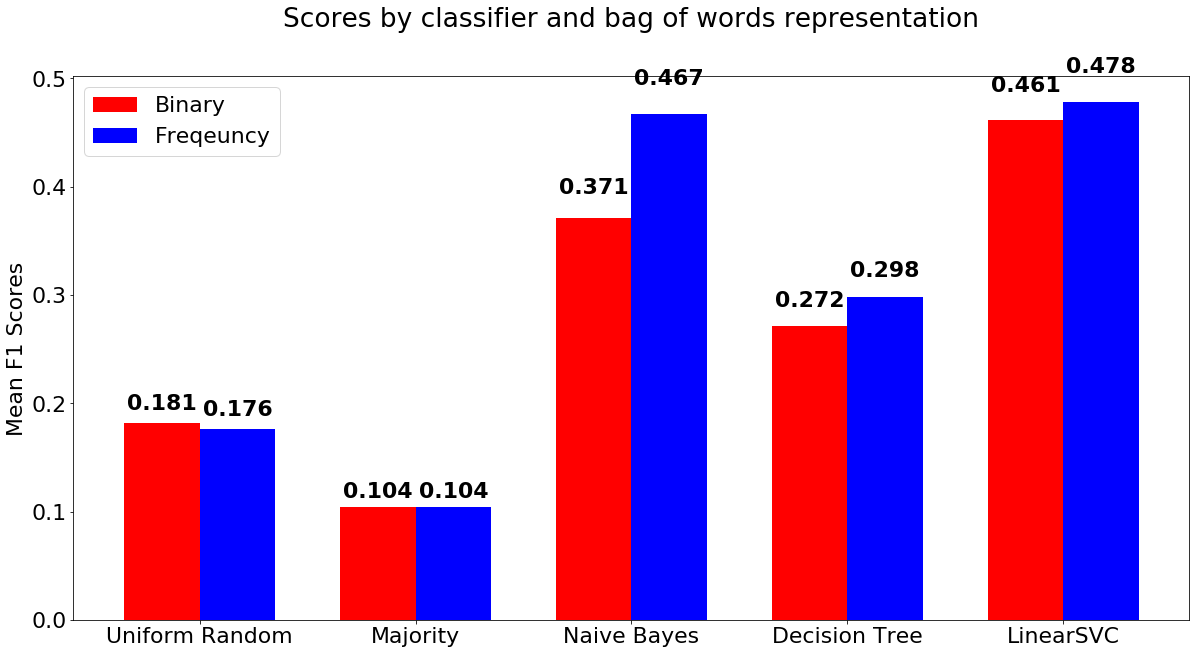

In [32]:
# Some visualization for the results
N = 5

Bin_U_f = f1_score(yelp_test.loc[:, [1]].astype(int), pd.DataFrame(yelp_uniform_random_classifier.predict(yelp_test_binary_matrix)).astype(int), 
                       average='macro')

Bin_M_f = f1_score(yelp_test.loc[:, [1]].astype(int), pd.DataFrame(yelp_majority_classifier.predict(yelp_test_binary_matrix)).astype(int), 
                       average='macro')

Bin_NB_f = f1_score(yelp_test.loc[:, [1]].astype(int), pd.DataFrame(yelp_binary_NBC.predict(yelp_test_binary_matrix)).astype(int), 
                       average='macro')

Bin_DT_f = f1_score(yelp_test.loc[:, [1]].astype(int), pd.DataFrame(yelp_binary_DTC.predict(yelp_test_binary_matrix)).astype(int), 
                       average='macro')

Bin_LSVC_f = f1_score(yelp_test.loc[:, [1]].astype(int), pd.DataFrame(yelp_binary_LSVC.predict(yelp_test_binary_matrix)).astype(int), 
                       average='macro')

binary_f_means = (Bin_U_f, Bin_M_f, Bin_NB_f, Bin_DT_f, Bin_LSVC_f)

ind = np.arange(N)
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(ind, binary_f_means, width, color='r')

Freq_U_f = f1_score(yelp_test.loc[:, [1]].astype(int), pd.DataFrame(yelp_uniform_random_classifier.predict(yelp_test_frequency_matrix)).astype(int), 
                       average='macro')

Freq_M_f = f1_score(yelp_test.loc[:, [1]].astype(int), pd.DataFrame(yelp_majority_classifier.predict(yelp_test_frequency_matrix)).astype(int), 
                       average='macro')

Freq_NB_f = f1_score(yelp_test.loc[:, [1]].astype(int), pd.DataFrame(yelp_freq_NBC.predict(yelp_test_frequency_matrix)).astype(int), 
                       average='macro')

Freq_DT_f = f1_score(yelp_test.loc[:, [1]].astype(int), pd.DataFrame(yelp_freq_DTC.predict(yelp_test_frequency_matrix)).astype(int), 
                       average='macro')

Freq_LSVC_f = f1_score(yelp_test.loc[:, [1]].astype(int), pd.DataFrame(yelp_freq_LSVC.predict(yelp_test_frequency_matrix)).astype(int), 
                       average='macro')

freq_f_means = (Freq_U_f, Freq_M_f, Freq_NB_f, Freq_DT_f, Freq_LSVC_f)
rects2 = ax.bar(ind + width, freq_f_means, width, color='b')

# add some text for labels, title and axes ticks
ax.set_ylabel('Mean F1 Scores')
ax.set_title('Scores by classifier and bag of words representation',  y=1.08)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Uniform Random', 'Majority', 'Naive Bayes', 'Decision Tree', 'LinearSVC'))

ax.legend((rects1[0], rects2[0]), ('Binary', 'Freqeuncy'))


def autolabel(rects, labels):
    """
    Attach a text label above each bar displaying its height
    """
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.3f' % label,
                ha='center', va='bottom', fontweight = 'bold')

autolabel(rects1, binary_f_means)
autolabel(rects2, freq_f_means)

plt.show()

### Observations:

- All models preformed better than the baseline
- Frequency bag-of-words representation consistently produced better results
- LinearSVC preformed the best, although it is worth mentioning that on the frequency representation Naive Bayes preformed very similarly and only took a fraction of the time to train.

### Q4:

I will repeat the exact same pipeline as in the previous questions on the IMDB datasets, starting with setting a baseline with the uniform random and majority classifiers. Note that because this is a weighted 2-class dataset the weighted mean f1 and mean f1 scores will all be the same (so I will only report the mean from here on):

In [33]:
IMDB_train_binary_matrix = binary_vectorize_toMatrix(IMDB_train)
IMDB_valid_binary_matrix = binary_vectorize_toMatrix(IMDB_valid)
IMDB_test_binary_matrix = binary_vectorize_toMatrix(IMDB_test)

IMDB_uniform_random_classifier = DummyClassifier(strategy='uniform')

IMDB_uniform_random_classifier = auto_training(IMDB_uniform_random_classifier, IMDB_train_binary_matrix, IMDB_train[1], IMDB_valid_binary_matrix,
              IMDB_valid[1], IMDB_test_binary_matrix, IMDB_test[1], speedy=False, full_results=True)

------------------------------------------------
DummyClassifier(constant=None, random_state=None, strategy='uniform')
*****************
Train Data Performance:
*****************
Confusion Matrix: 
 [[3722 3778]
 [3793 3707]]
F1 Score:  0.495266666667
Mean F1 Score:  0.495266161933
Weighted Mean F1 Score:  0.495266161933
*****************
Validation Data Performance:
*****************
Confusion Matrix: 
 [[2512 2488]
 [2484 2516]]
F1 Score:  0.5028
Mean F1 Score:  0.502799920448
Weighted Mean F1 Score:  0.502799920448
*****************
Test Data Performance:
*****************
Confusion Matrix: 
 [[6244 6256]
 [6283 6217]]
F1 Score:  0.49844
Mean F1 Score:  0.49843941498
Weighted Mean F1 Score:  0.49843941498
------------------------------------------------




In [34]:
naive_bayes_params = dict(alpha=np.array([100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]),
                          fit_prior=[True, False])

IMDB_binary_NBC = auto_training(None, IMDB_train_binary_matrix, IMDB_train.loc[:, [1]], IMDB_valid_binary_matrix,
              IMDB_valid.loc[:, [1]], IMDB_test_binary_matrix, IMDB_test.loc[:, [1]], speedy=False,
              parameters=naive_bayes_params, model_name="Bernoulli", weighted_mean = False)

------------------------------------------------
BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)
Validation Data Performance:
*****************
Confusion Matrix: 
 [[4274  726]
 [ 842 4158]]
F1 Score:  0.8432
Mean F1 Score:  0.843178898153
*****************




In [35]:
narrowed_naive_bayes_params = dict(alpha=np.arange(0.002, 0.09, 0.001), fit_prior=[True])

IMDB_binary_NBC = auto_training(None, IMDB_train_binary_matrix, IMDB_train.loc[:, [1]], IMDB_valid_binary_matrix,
              IMDB_valid.loc[:, [1]], IMDB_test_binary_matrix, IMDB_test.loc[:, [1]], speedy=False, full_results = True, 
              parameters= narrowed_naive_bayes_params, model_name="Bernoulli", weighted_mean = False)

------------------------------------------------
BernoulliNB(alpha=0.014, binarize=0.0, class_prior=None, fit_prior=True)
*****************
Train Data Performance:
*****************
Confusion Matrix: 
 [[6654  846]
 [1079 6421]]
F1 Score:  0.871666666667
Mean F1 Score:  0.871635694356
*****************
Validation Data Performance:
*****************
Confusion Matrix: 
 [[4275  725]
 [ 841 4159]]
F1 Score:  0.8434
Mean F1 Score:  0.843378925068
*****************
Test Data Performance:
*****************
Confusion Matrix: 
 [[10819  1681]
 [ 2449 10051]]
F1 Score:  0.8348
Mean F1 Score:  0.834643950453
------------------------------------------------




In [36]:
decision_tree_params = dict(criteria=['gini', 'entropy'], splitter=['best', 'random'], max_depth=list(range(1, 10)),
                            min_samples_split= list(range(2, 10)), min_samples_leaf=list(range(1, 10)), class_weight=["balanced", None])

IMDB_binary_DTC = auto_training(None, IMDB_train_binary_matrix, IMDB_train.loc[:, [1]], IMDB_valid_binary_matrix,
              IMDB_valid.loc[:, [1]], IMDB_test_binary_matrix, IMDB_test.loc[:, [1]], speedy=False, full_results = True, 
              parameters= decision_tree_params, model_name="DecisionTree", weighted_mean = False)

------------------------------------------------
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=2,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
*****************
Train Data Performance:
*****************
Confusion Matrix: 
 [[7500    0]
 [7500    0]]
F1 Score:  0.5
Mean F1 Score:  0.333333333333
*****************
Validation Data Performance:
*****************
Confusion Matrix: 
 [[5000    0]
 [5000    0]]
F1 Score:  0.5
Mean F1 Score:  0.333333333333
*****************
Test Data Performance:
*****************
Confusion Matrix: 
 [[12500     0]
 [12500     0]]
F1 Score:  0.5
Mean F1 Score:  0.333333333333
------------------------------------------------




In [37]:
linear_SVC_params = dict(penalty=['l1', 'l2'], loss=['hinge', 'squared_hinge'], class_weight=[None, 'balanced'],
                         tol=np.array([1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.0000001, 0.00000001]), max_iter =[1000],
                         C=([1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.0000001, 0.00000001]))

IMDB_binary_LSVC = auto_training(None, IMDB_train_binary_matrix, IMDB_train.loc[:, [1]], IMDB_valid_binary_matrix,
              IMDB_valid.loc[:, [1]], IMDB_test_binary_matrix, IMDB_test.loc[:, [1]], speedy=False, 
              parameters= linear_SVC_params, model_name="LinearSVC", weighted_mean = False)

------------------------------------------------
LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None,
     tol=0.10000000000000001, verbose=0)
Validation Data Performance:
*****************
Confusion Matrix: 
 [[4362  638]
 [ 593 4407]]
F1 Score:  0.8769
Mean F1 Score:  0.876897507175
*****************




In [38]:
narrowed_linear_SVC_params = dict(penalty=['l2'], loss=['squared_hinge'], class_weight=['balanced'],
                         tol=np.arange(0.2, 9.9, 0.1), max_iter =[1000, 10000],
                         C=np.arange(0.002, 0.099, 0.001))

IMDB_binary_LSVC = auto_training(None, IMDB_train_binary_matrix, IMDB_train.loc[:, [1]], IMDB_valid_binary_matrix,
              IMDB_valid.loc[:, [1]], IMDB_test_binary_matrix, IMDB_test.loc[:, [1]], speedy=False, full_results = True, 
              parameters= narrowed_linear_SVC_params, model_name="LinearSVC", weighted_mean = False)

------------------------------------------------
LinearSVC(C=0.0060000000000000001, class_weight='balanced', dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=1.6000000000000003, verbose=0)
*****************
Train Data Performance:
*****************
Confusion Matrix: 
 [[7109  391]
 [ 327 7173]]
F1 Score:  0.952133333333
Mean F1 Score:  0.952132461931
*****************
Validation Data Performance:
*****************
Confusion Matrix: 
 [[4376  624]
 [ 587 4413]]
F1 Score:  0.8789
Mean F1 Score:  0.878898342118
*****************
Test Data Performance:
*****************
Confusion Matrix: 
 [[10925  1575]
 [ 1572 10928]]
F1 Score:  0.87412
Mean F1 Score:  0.874119998187
------------------------------------------------




Now with frequency bag-of-words representation:

In [39]:
IMDB_train_frequency_matrix = frequency_vectorize_toMatrix(IMDB_train)
IMDB_valid_frequency_matrix = frequency_vectorize_toMatrix(IMDB_valid)
IMDB_test_frequency_matrix = frequency_vectorize_toMatrix(IMDB_test)

IMDB_freq_NBC = auto_training(None, IMDB_train_frequency_matrix, IMDB_train.loc[:, [1]], IMDB_valid_frequency_matrix,
              IMDB_valid.loc[:, [1]], IMDB_test_frequency_matrix, IMDB_test.loc[:, [1]], speedy=False,
              parameters=naive_bayes_params, model_name="Multinomial", weighted_mean = False)

------------------------------------------------
MultinomialNB(alpha=0.0001, class_prior=None, fit_prior=True)
Validation Data Performance:
*****************
Confusion Matrix: 
 [[4230  770]
 [ 735 4265]]
F1 Score:  0.8495
Mean F1 Score:  0.849498156352
*****************




In [40]:
narrowed_naive_bayes_params = dict(alpha=np.arange(0.00002, 0.00099, 0.00001), fit_prior=[True])

IMDB_freq_NBC = auto_training(None, IMDB_train_frequency_matrix, IMDB_train.loc[:, [1]], IMDB_valid_frequency_matrix,
              IMDB_valid.loc[:, [1]], IMDB_test_frequency_matrix, IMDB_test.loc[:, [1]], speedy=False, full_results = True, 
              parameters=narrowed_naive_bayes_params, model_name="Multinomial", weighted_mean = False)

------------------------------------------------
MultinomialNB(alpha=0.00010000000000000002, class_prior=None, fit_prior=True)
*****************
Train Data Performance:
*****************
Confusion Matrix: 
 [[6611  889]
 [ 882 6618]]
F1 Score:  0.881933333333
Mean F1 Score:  0.881933307621
*****************
Validation Data Performance:
*****************
Confusion Matrix: 
 [[4230  770]
 [ 735 4265]]
F1 Score:  0.8495
Mean F1 Score:  0.849498156352
*****************
Test Data Performance:
*****************
Confusion Matrix: 
 [[10612  1888]
 [ 2220 10280]]
F1 Score:  0.83568
Mean F1 Score:  0.835651015676
------------------------------------------------




In [41]:
IMDB_freq_DTC = auto_training(None, IMDB_train_frequency_matrix, IMDB_train.loc[:, [1]], IMDB_valid_frequency_matrix,
              IMDB_valid.loc[:, [1]], IMDB_test_frequency_matrix, IMDB_test.loc[:, [1]], speedy=False, full_results = True, 
              parameters= decision_tree_params, model_name="DecisionTree", weighted_mean = False)

------------------------------------------------
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=2,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
*****************
Train Data Performance:
*****************
Confusion Matrix: 
 [[7500    0]
 [7500    0]]
F1 Score:  0.5
Mean F1 Score:  0.333333333333
*****************
Validation Data Performance:
*****************
Confusion Matrix: 
 [[5000    0]
 [5000    0]]
F1 Score:  0.5
Mean F1 Score:  0.333333333333
*****************
Test Data Performance:
*****************
Confusion Matrix: 
 [[12500     0]
 [12500     0]]
F1 Score:  0.5
Mean F1 Score:  0.333333333333
------------------------------------------------




In [42]:
IMDB_freq_LSVC = auto_training(None, IMDB_train_frequency_matrix, IMDB_train.loc[:, [1]], IMDB_valid_frequency_matrix,
              IMDB_valid.loc[:, [1]], IMDB_test_frequency_matrix, IMDB_test.loc[:, [1]], speedy=False, 
              parameters= linear_SVC_params, model_name="LinearSVC", weighted_mean = False)

------------------------------------------------
LinearSVC(C=100, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None,
     tol=1.0000000000000001e-05, verbose=0)
Validation Data Performance:
*****************
Confusion Matrix: 
 [[4357  643]
 [ 557 4443]]
F1 Score:  0.88
Mean F1 Score:  0.879991124144
*****************




In [43]:
narrowed_linear_SVC_params = dict(penalty=['l2'], loss=['squared_hinge'], class_weight=['balanced'],
                         tol= np.arange(0.00001, 0.00009, 0.00001), max_iter=[1000, 10000], C= np.arange(100, 1000, 100))

IMDB_freq_LSVC = auto_training(None, IMDB_train_frequency_matrix, IMDB_train.loc[:, [1]], IMDB_valid_frequency_matrix,
              IMDB_valid.loc[:, [1]], IMDB_test_frequency_matrix, IMDB_test.loc[:, [1]], speedy=False, full_results = True, 
              parameters= narrowed_linear_SVC_params, model_name="LinearSVC", weighted_mean = False)

------------------------------------------------
LinearSVC(C=200, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None,
     tol=4.0000000000000003e-05, verbose=0)
*****************
Train Data Performance:
*****************
Confusion Matrix: 
 [[7077  423]
 [ 235 7265]]
F1 Score:  0.956133333333
Mean F1 Score:  0.95612644148
*****************
Validation Data Performance:
*****************
Confusion Matrix: 
 [[4277  723]
 [ 478 4522]]
F1 Score:  0.8799
Mean F1 Score:  0.879827866677
*****************
Test Data Performance:
*****************
Confusion Matrix: 
 [[10662  1838]
 [ 1358 11142]]
F1 Score:  0.87216
Mean F1 Score:  0.872112855683
------------------------------------------------




## Summary



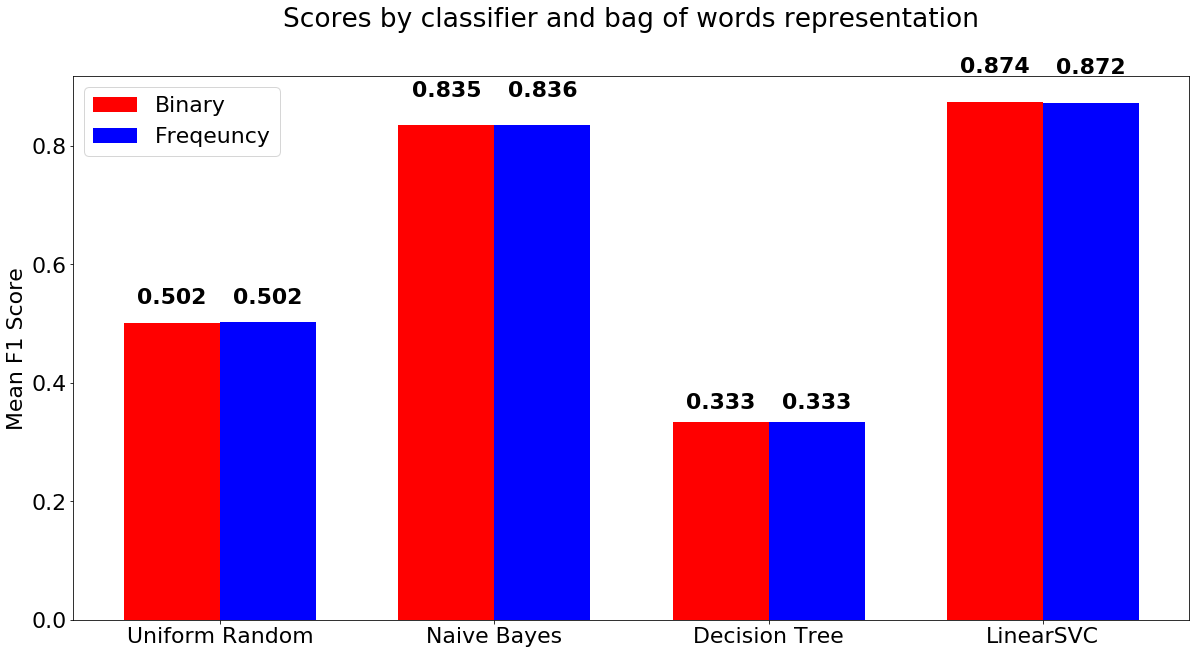

In [51]:
# Some visualization for the results
N = 4

I_Bin_U_f = f1_score(IMDB_test.loc[:, [1]].astype(int), pd.DataFrame(IMDB_uniform_random_classifier.predict(IMDB_test_binary_matrix)).astype(int), 
                       average='macro')

I_Bin_NB_f = f1_score(IMDB_test.loc[:, [1]].astype(int), pd.DataFrame(IMDB_binary_NBC.predict(IMDB_test_binary_matrix)).astype(int), 
                       average='macro')

I_Bin_DT_f = f1_score(IMDB_test.loc[:, [1]].astype(int), pd.DataFrame(IMDB_binary_DTC.predict(IMDB_test_binary_matrix)).astype(int), 
                       average='macro')

I_Bin_LSVC_f = f1_score(IMDB_test.loc[:, [1]].astype(int), pd.DataFrame(IMDB_binary_LSVC.predict(IMDB_test_binary_matrix)).astype(int), 
                       average='macro')

I_binary_f_means = (I_Bin_U_f, I_Bin_NB_f, I_Bin_DT_f, I_Bin_LSVC_f)

ind2 = np.arange(N)
width = 0.35

fig, ax = plt.subplots()
rects3 = ax.bar(ind2, I_binary_f_means, width, color='r')

I_Freq_U_f = f1_score(IMDB_test.loc[:, [1]].astype(int), pd.DataFrame(IMDB_uniform_random_classifier.predict(IMDB_test_frequency_matrix)).astype(int), 
                       average='macro')

I_Freq_NB_f = f1_score(IMDB_test.loc[:, [1]].astype(int), pd.DataFrame(IMDB_freq_NBC.predict(IMDB_test_frequency_matrix)).astype(int), 
                       average='macro')

I_Freq_DT_f = f1_score(IMDB_test.loc[:, [1]].astype(int), pd.DataFrame(IMDB_freq_DTC.predict(IMDB_test_frequency_matrix)).astype(int), 
                       average='macro')

I_Freq_LSVC_f = f1_score(IMDB_test.loc[:, [1]].astype(int), pd.DataFrame(IMDB_freq_LSVC.predict(IMDB_test_frequency_matrix)).astype(int), 
                       average='macro')

I_freq_f_means = (I_Freq_U_f, I_Freq_NB_f, I_Freq_DT_f, I_Freq_LSVC_f)

rects4 = ax.bar(ind2 + width, I_freq_f_means, width, color='b')

# add some text for labels, title and axes ticks
ax.set_ylabel('Mean F1 Score')
ax.set_title('Scores by classifier and bag of words representation',  y=1.08)
ax.set_xticks(ind2 + width / 2)
ax.set_xticklabels(('Uniform Random', 'Naive Bayes', 'Decision Tree', 'LinearSVC'))

ax.legend((rects3[0], rects4[0]), ('Binary', 'Freqeuncy'))


def autolabel(rects, labels):
    """
    Attach a text label above each bar displaying its height
    """
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.3f' % label,
                ha='center', va='bottom', fontweight = 'bold')

autolabel(rects3, I_binary_f_means)
autolabel(rects4, I_freq_f_means)

plt.show()

### Observations:

The "Unreasonable Effectiveness of Data" is shown quite clearly here. The fact that we used a weighted dataset for a 2-class problem influenced the results of the classifiers more than any hyperparemeter tuning, and led to some interesting properties, namely:

- There is negligible difference in the preformance of the binary and frequency bag of words representations
- The Decision Tree classifier preformed worse than the baseline, and looking at the classifier's properties one can see that the maximum depth is only 1, likely because the dataset is weighted (and entropy/information gain doesn't work as well on 2-class datasets) so the best prediction is either branching to class 1 or class 2 from the start
- All the classifiers preformed better than the classifiers on the yelp dataset